FORKED from 07-TFM-CarDrawing-FirstAprox-Unet-segment-mask

**Partimos del notebook 07 intentaremos la maskara nuevamente con augmentacióm**

En el Notebook 08 hemos detectado que aplicando la mascara entrenada en el Carvana no produce resultados muy buenos en el dataset de Standford.

En el primero intento de entrenar la mascara NO hemos usado augmentación, así que vamos a repetir el noteboob 07 (train segmentation mask) aplicando augmentación con el objetivo de mejorar el modelo


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))

import numpy as np
import pandas as pd
import os
from skimage.transform import resize
from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img
from skimage.io import imread, imshow #, concatenate_images
import PIL 
from PIL import Image
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

['manualdraw', 'carvana-image-masking-challenge', 'stanford-car-dataset-by-classes-folder']


Using TensorFlow backend.


Preparamos unas cuantas funciones para leer del directorio

In [2]:
def files_names_in_path(path="",extension=".jpg"):
    files = []
    masks = []
    for f in os.listdir(path):
        filename, file_extension = os.path.splitext(f)
        if file_extension == '.gif':
            files.append(filename.replace('_mask','')+".jpg")
            masks.append(filename+"_mask.gif")
            
    return files, masks
car_path = '../input/carvana-image-masking-challenge/train/'
mask_path = '../input/carvana-image-masking-challenge/train_masks/'
input_files,input_masks = files_names_in_path(mask_path)

print(input_files[0:5])


['189a2a32a615_06.jpg', '2ea62c1beee7_05.jpg', '189a2a32a615_14.jpg', 'ef5567efd904_09.jpg', 'c53e374fdd72_14.jpg']


[[[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 [[0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  [0.95686275 0.95294118 0.97254902]
  ...
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]
  [0.91764706 0.90196078 0.90588235]]

 ...

 [[0.83137255 0.82745098 0.84705882]
  [0.83137255 0.82745098 0.84705882]
  [0.83137255 0.82745098 0.84705882]
  ...
  [0.88627451 0.88627451 0.88627451]
  [0.88627451 0.88627451 0.88627451]
  [0.88627451 0.88627451 0.88627451]]

 [[0.83137255 0.82745098 0.84705882]
  [0.83137255 0.82745098 0.84705882]


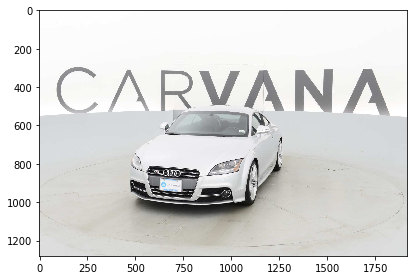

In [3]:
def load_image_and_normalize_and_resize(file_path="",normalize=True):
    if normalize:
        return (imread(file_path)/255)
    else:
        return (imread(file_path))
    

print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]))
print(imshow(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,2)[0])))
print(load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape)
HEIGH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[0]
WIDTH = load_image_and_normalize_and_resize(car_path+np.random.choice(input_files,1)[0]).shape[1]

In [4]:
mask = pd.read_csv('../input/carvana-image-masking-challenge/train_masks.csv')

In [5]:
len(mask)

5088

In [6]:
# empezamos a trabajar para obtener la mascara del coche solo nos interesa el coche para mejorar el performanc
# ademas queremos simular los trazos humanos extrayendo los edges del coche (pero solo del coche, el fondo no nos interesa)
import cv2
indx=5000
carimage = car_path+input_files[indx]
maskimage = mask_path+input_files[indx].replace('.jpg','_mask.gif')

print(carimage)
print(maskimage)
img = cv2.imread(carimage)
#mask = cv2.imread(maskimage)
mask=imread(maskimage)
print(mask)



../input/carvana-image-masking-challenge/train/70b6a79565fe_10.jpg
../input/carvana-image-masking-challenge/train_masks/70b6a79565fe_10_mask.gif
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


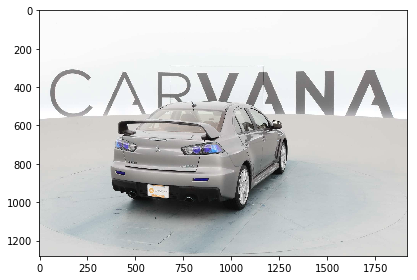

In [7]:
#La imagen original
imshow(img)

(1280, 1918)


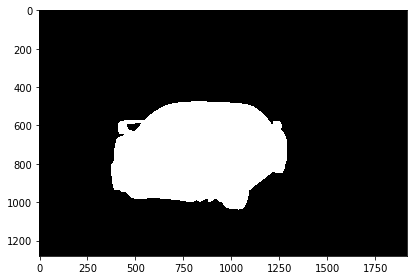

In [8]:
#La mascara
print(mask.shape)
imshow(mask)

In [9]:
from sklearn.model_selection import train_test_split
train_input, test_input, _, _ = train_test_split(input_files, input_files, test_size=0.15, random_state=42)
print(len(train_input))
print(len(test_input))

4324
764


In [10]:
np.random.choice(train_input,1)
train_input[0]

'fc237174b128_08.jpg'

In [11]:
H = 256
W = 256

def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

carimage = car_path+str(train_input[0])
maskimage = mask_path+str(train_input[0]).replace('.jpg','_mask.gif')

img = downsample(imread(carimage)/255, H, W)
mask=downsample(imread(maskimage)/255, H, W)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


**NO PODEMOS USAR UN AUGMENTADER ESTANDARD**
La mayoria de augmentadores preparados no estan preparados para nuestro problema, ya que la misma augmentación que aplicamos a la imagen original deberia de aplicarse tambien a la mascara.

Primero intentaremos augmentaciónes de manera indivisual y luego las añadiremos todas juntas en un generador

**READINGS!**



    http://scikit-image.org/docs/dev/api/skimage.transform.html
    http://scikit-image.org/docs/dev/api/skimage.exposure.html
    http://scikit-image.org/docs/dev/api/skimage.filters.html
    http://scikit-image.org/docs/dev/auto_examples/xx_applications/plot_geometric.html
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
    https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced
    https://machinelearningmastery.com/image-augmentation-deep-learning-keras/


In [12]:
# nos definimos funcion de plot facil...
def plot_tuple(orig, augmented, orig_mask, augmented_mask):
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
    
    ax1[0].imshow(orig, cmap='gray')
    ax1[1].imshow(augmented, cmap='gray')
    ax2[0].imshow(orig_mask, cmap='gray')
    ax2[1].imshow(augmented_mask, cmap='gray')
    
    plt.tight_layout()

0.0024


NameError: name 'pl' is not defined

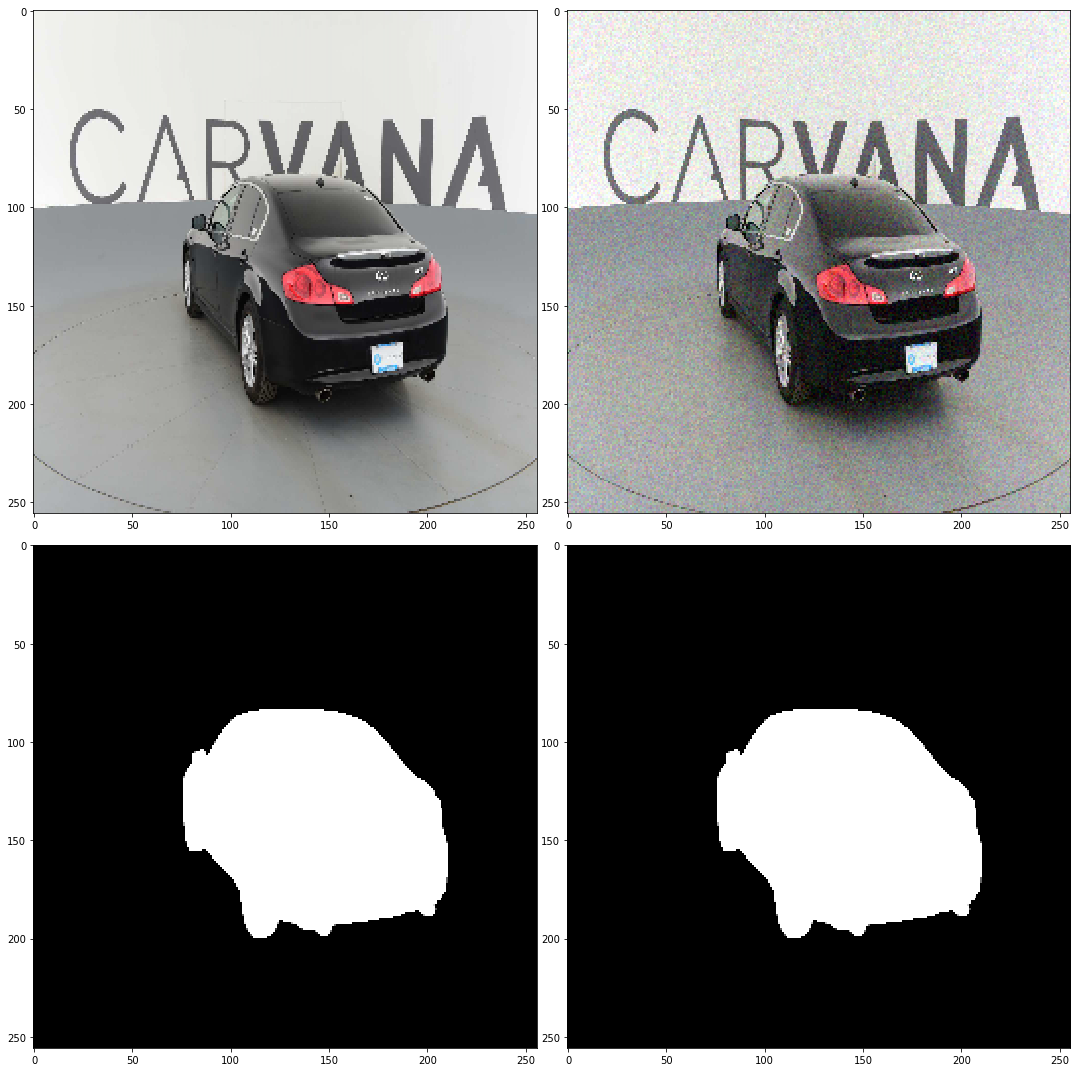

In [13]:
# trying to add random noise
from skimage.transform import warp, AffineTransform, ProjectiveTransform
from skimage.exposure import equalize_adapthist, equalize_hist, rescale_intensity, adjust_gamma, adjust_log, adjust_sigmoid
from skimage.filters import gaussian
from skimage.util import random_noise
import random



def randRange(a, b):
    return pl.rand() * (b - a) + a

var = np.random.randint(0,1000)/100000
print(var)
rand_aug = random_noise(img, mode='gaussian', var=var)
#random noise a la mascara NO se aplica
plot_tuple(img, rand_aug, mask, mask)
#salt #peper
#rand_aug = random_noise(img, mode='salt', var=var)
#plot_tuple(img, rand_aug, mask, mask)

#rand_aug = random_noise(img, mode='pepper', var = var)
#plot_tuple(img, rand_aug, mask, mask)

#OK tenemos random noise con 3 parametros gaussian salt y pepper


def randomGaussian(img, mask):
    return gaussian(img, sigma=randRange(0, 2)), mask

rand_aug, rand_mask=randomGaussian(img, mask)
plot_tuple(img, rand_aug, mask, rand_mask)

In [14]:
# vamos a intenart zoom in zoomt out and crop

In [15]:
#aqui si el mismo crop que aplicamos a la imagen de entrada lo aplicamos a la mascara tambien
import pylab as pl # linear algebra + plotting

def randRange(a, b):
    return pl.rand() * (b - a) + a

def randomCrop(image, mask):
    mar = np.random.randint(1,15)
    margin = 1/mar
    rand1 = randRange(0, image.shape[0] * margin)
    rand2 = randRange(0, image.shape[1] * margin)
    start = [int(rand1),
             int(rand2)]
    rand3=int(randRange(image.shape[0] * (1-margin), image.shape[0]))
    rand4=int(randRange(image.shape[1] * (1-margin), image.shape[1]))
    end = [rand3, 
           rand4]
    return image[start[0]:end[0], start[1]:end[1]], mask[start[0]:end[0], start[1]:end[1]]

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256, 3)
(256, 256)


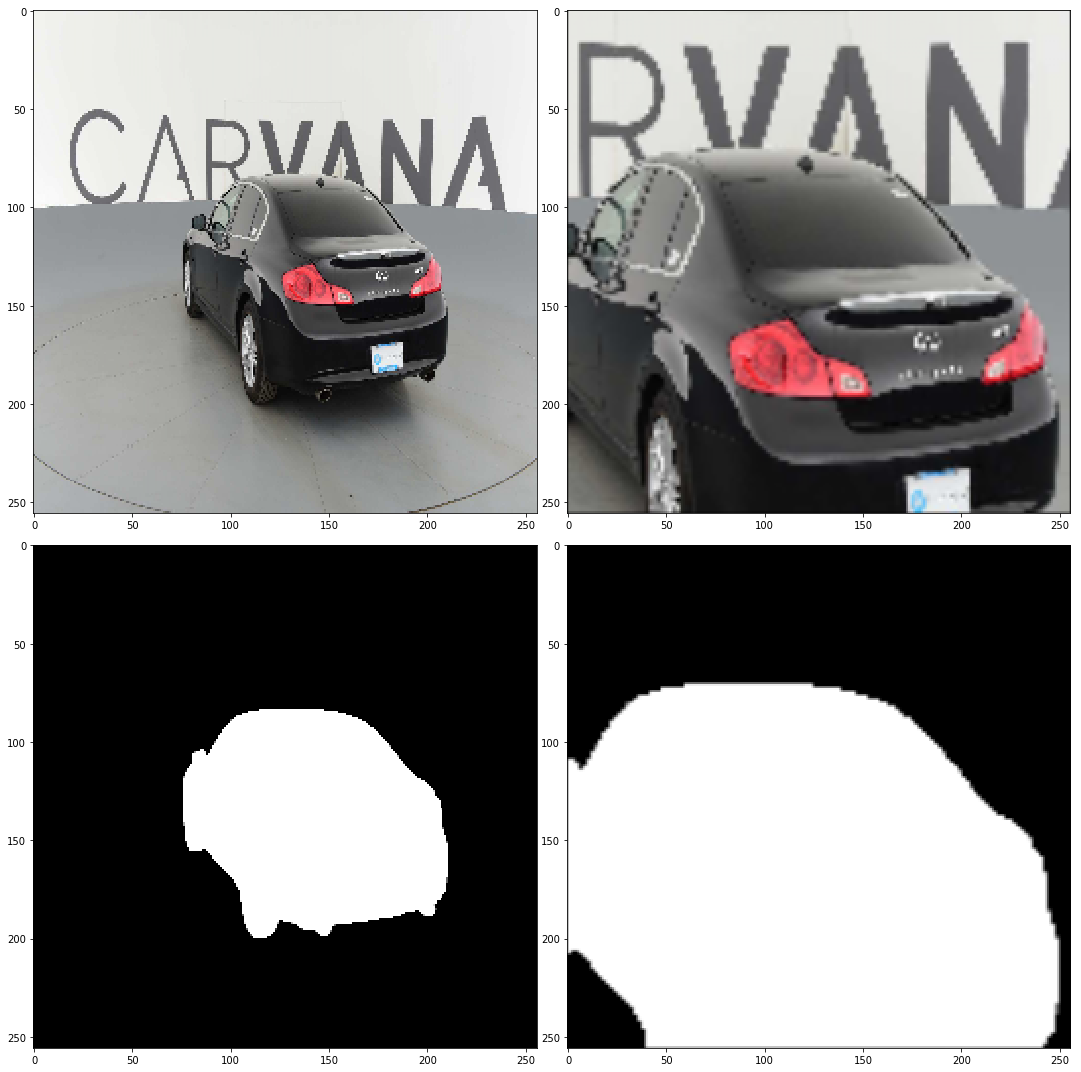

In [16]:
aug, aug_mask = randomCrop(img,mask)
aug =  downsample(aug,H,W)
aug_mask =downsample(aug_mask,H,W)
plot_tuple(img, aug, mask, aug_mask )
print(aug.shape)
print(aug_mask.shape)

# tengo dudas si esta bien echo...
# mmm... no me gusta mucho... lo augmentacion en la imagen i mascara se mantiene.. el problema es que solo eliminamos
# un poco el margen a la izquierda
# no esta mal mejor esto que nada


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(256, 256, 3)


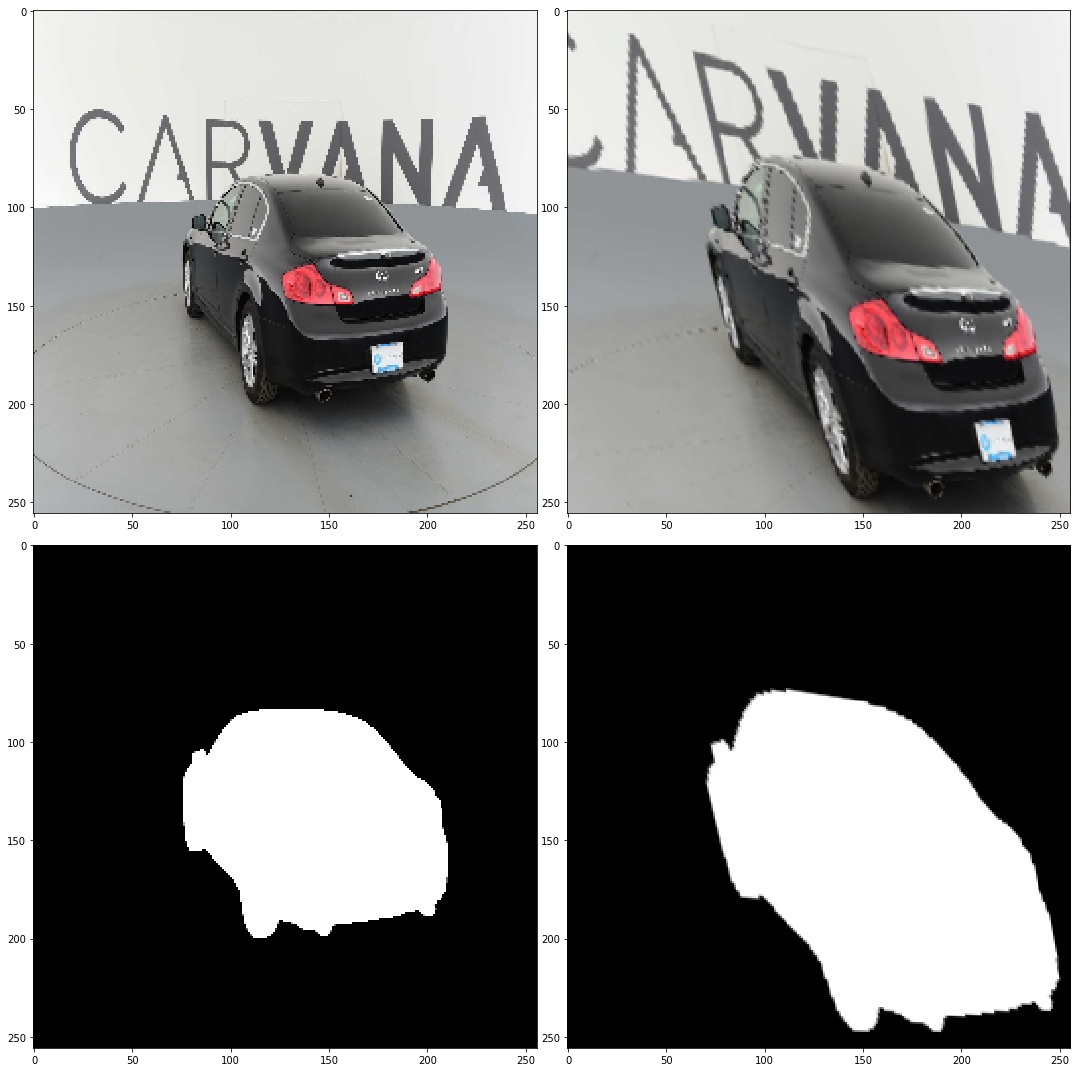

In [17]:

def randomPerspective(im,mask):
    
    region = 1/4
    A = pl.array([[0, 0], [0, im.shape[0]], [im.shape[1], im.shape[0]], [im.shape[1], 0]])
    B = pl.array([[int(randRange(0, im.shape[1] * region)), int(randRange(0, im.shape[0] * region))], 
                  [int(randRange(0, im.shape[1] * region)), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(im.shape[0] * (1-region), im.shape[0]))], 
                  [int(randRange(im.shape[1] * (1-region), im.shape[1])), int(randRange(0, im.shape[0] * region))], 
                 ])

    pt = ProjectiveTransform()
    pt.estimate(A, B)
    
    return warp(im, pt, output_shape=im.shape[:2]), warp(mask, pt, output_shape=im.shape[:2])

aug, aug_mask = randomPerspective(img,mask)
aug =  downsample(aug,H,W)
aug_mask =downsample(aug_mask,H,W)
plot_tuple(img, aug, mask, aug_mask)
print(aug.shape)
#print(aug_mask.shape)


In [18]:
np.random.randint(0,2)

1

In [19]:
def augmentation(image, mascara):
    noise = np.random.randint(0,3)
    
    newimg = image
    newmask = mascara
    
    if noise == 1:
        #aplicamos randomroise
        var = np.random.randint(0,1000)/100000
        newimg = random_noise(image, mode='gaussian', var=var)
    elif noise == 2: 
        #applicamos gaussian noise
        newimg = gaussian(image, sigma=randRange(0, 2))
    #sino no aplicamos ruidos dejamos la original
    
    crop = np.random.randint(0,2)
    
    if crop == 1:
        #aplicamos crop
        #print("CROP")
        #newimg, newmask = randomCrop(newimg, newmask)
    #elif crop == 2:
        #print("prespective")
        newimg, newmask = randomPerspective(newimg, newmask)
  
        
        
     ## ¿Nos falta algun agumentador que canvie el color?? bueno vamos a ver que tal va este   
    
    
    return newimg, newmask
    
    
    

In [20]:
H = 256
W = 256
BATCH_SIZE=32
def downsample(img, h, w):    
    ret = resize(img, (h, w), mode='constant', preserve_range=True)
    # plt.imshow(ret)
    return ret
    #return cv2.resize(img, (h, w))

def generator_resize(path, batch_size, h, w):
    
    while True:
        input_img=[]
        output_mask=[]
        for x in range(batch_size):
            selected = np.squeeze(np.random.choice(path,1))
            carimage = car_path+str(selected)
            maskimage = mask_path+str(selected).replace('.jpg','_mask.gif')
            
            img = imread(carimage)
            mask = imread(maskimage)
            
            img, mask = augmentation(img/255, mask/255)

            # added custom augmentation
            #img, mask = augmentation(img,mask)      
            img = downsample(img, h, w)
            mask = downsample(mask, h, w)
            
            #mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
            input_img.append(img)
            output_mask.append(mask.reshape(h,w,1))
            
        yield np.array(input_img), np.array(output_mask)
        
imgs,masks=next(generator_resize(train_input,BATCH_SIZE, H, W))
print(imgs.shape)
print(masks.shape)
print(np.max(imgs))
print(np.max(masks))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


(32, 256, 256, 3)
(32, 256, 256, 1)
1.0000000000000004
1.0


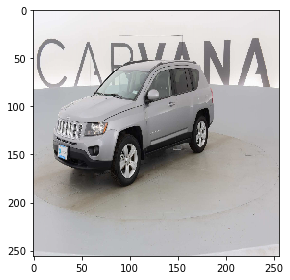

In [21]:
imshow(imgs[3])

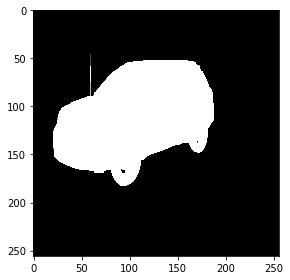

In [22]:
imshow(masks[3].reshape(H,W))

In [23]:
#Vamos a entrenar nuestra Unet classica salidas sigmoid y binarycrossentropy

In [24]:
#Based on my custom old experiments with U-Net
#https://github.com/nopaixx/Py-Models/blob/master/MODEL02-Tensoflow%20Keras%20Unet%20Image%20segmentation.ipynb

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
input_img = Input((H, W, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [25]:
#definimos nuestro callback para guardar
saver = ModelCheckpoint('unet-carvana-augmented.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [26]:
histo = model.fit_generator(generator_resize(train_input,BATCH_SIZE, H, W),steps_per_epoch=10, epochs=40,
                    validation_data=generator_resize(test_input,BATCH_SIZE, H, W),validation_steps=10,
                    callbacks=[saver])

Instructions for updating:
Use tf.cast instead.
Epoch 1/40


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


10/10 [==============================] - 350s 35s/step - loss: 0.5152 - acc: 0.8036 - val_loss: 0.6202 - val_acc: 0.8451
Epoch 2/40
10/10 [==============================] - 322s 32s/step - loss: 0.2912 - acc: 0.9415 - val_loss: 1.8922 - val_acc: 0.7921
Epoch 3/40
10/10 [==============================] - 340s 34s/step - loss: 0.2418 - acc: 0.9589 - val_loss: 0.7878 - val_acc: 0.8909
Epoch 4/40
10/10 [==============================] - 338s 34s/step - loss: 0.2187 - acc: 0.9701 - val_loss: 0.2650 - val_acc: 0.9547
Epoch 5/40
10/10 [==============================] - 321s 32s/step - loss: 0.1972 - acc: 0.9735 - val_loss: 0.1767 - val_acc: 0.9759
Epoch 6/40
10/10 [==============================] - 320s 32s/step - loss: 0.1851 - acc: 0.9760 - val_loss: 0.1722 - val_acc: 0.9740
Epoch 7/40
10/10 [==============================] - 329s 33s/step - loss: 0.1686 - acc: 0.9773 - val_loss: 0.1591 - val_acc: 0.9732
Epoch 8/40
10/10 [==============================] - 336s 34s/step - loss: 0.1544 - acc:

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


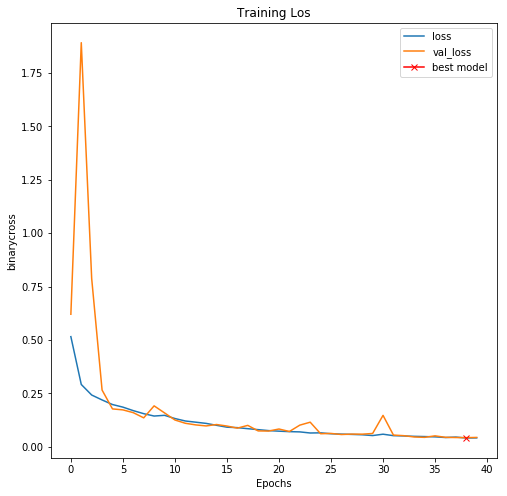

In [27]:

plt.figure(figsize=(8, 8))
plt.title("Training Los")
plt.plot(histo.history["loss"], label="loss")
plt.plot(histo.history["val_loss"], label="val_loss")
plt.plot( np.argmin(histo.history["val_loss"]), np.min(histo.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("binarycross")
plt.legend();

In [28]:
!ls

__notebook__.ipynb  __output__.json  unet-carvana-augmented.hdf5


In [29]:
inp,out=next(generator_resize(test_input,BATCH_SIZE, H, W))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


In [30]:
pred = model.predict(inp)

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


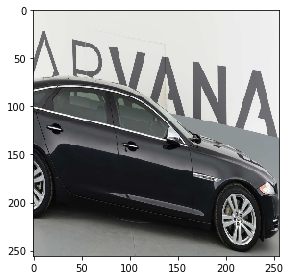

In [31]:
imshow(inp[0])

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


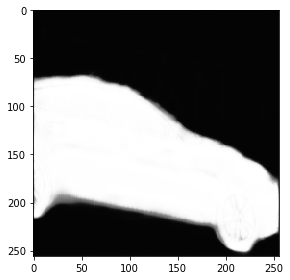

In [32]:
imshow(pred[0].reshape(H,W))

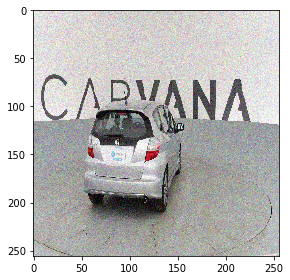

In [33]:
imshow(inp[1])

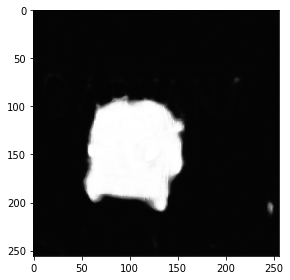

In [34]:
imshow(pred[1].reshape(H,W))

/opt/conda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


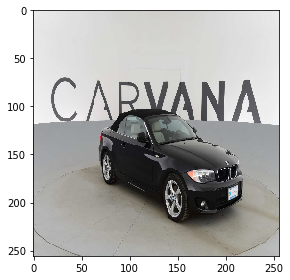

In [35]:
imshow(inp[2])

/opt/conda/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


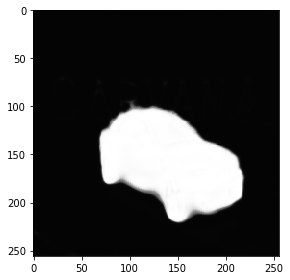

In [36]:
imshow(pred[2].reshape(H,W))